<a href="https://colab.research.google.com/github/byewokko/guessing-game/blob/master/Guessing_game_REINFORCE_2.4.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run once to get functions and datasets from my guessing-game repo
# !wget https://raw.githubusercontent.com/byewokko/guessing-game/master/game/game.py
# !wget https://raw.githubusercontent.com/byewokko/guessing-game/master/utils/dataprep.py
# !wget https://github.com/byewokko/guessing-game/raw/master/data/imagenet-200x65-vgg19.train.emb.gz

In [1]:
import tensorflow.keras
if True or list(map(int, keras.__version__.split("."))) < [2,4,0]:
    import tensorflow.keras.layers as layers
    import tensorflow.keras.backend as K
    import tensorflow.keras.optimizers as optim
    from tensorflow.keras.models import Model, Sequential
else:
    import keras.layers as layers
    import keras.backend as K
    import keras.optimizers as optim
    from keras.models import Model, Sequential
    
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from game.game import Game

In [2]:
from utils.dataprep import load_emb_gz, make_categories

DATASET = "data/imagenet-200x65-vgg19.train.emb.gz"

path2ind, path_list, embeddings = load_emb_gz(DATASET)
categories = make_categories(path_list, sep="\\")

IMAGE_SHAPE = [len(embeddings[0])]

DONE. 13190 items loaded from data/imagenet-200x65-vgg19.train.emb.gz.
200 categories found.


In [3]:
from utils.dataprep import load_emb_pickled

DATASET = "data/big/mcrae-wordnet-vgg16.32bit"

metadata, embeddings = load_emb_pickled(DATASET)
filenames = metadata.get("fnames")
categories = metadata.get("categories")

IMAGE_SHAPE = [len(embeddings[0])]

Loading features from data/big/mcrae-wordnet-vgg16.32bit.npy.gz
Loading metadata from data/big/mcrae-wordnet-vgg16.32bit.meta.pkl
4 categories found.


In [4]:
N_IMAGES = 4
EMBEDDING_SIZE = 50
VOCABULARY_SIZE = 100

TEMPERATURE = 10
N_EPISODES = 50000
ANALYSIS_WINDOW = 50
BATCH_SIZE = 30

LEARNING_RATE = 0.1
OPTIMIZER = optim.Adam
# OPTIMIZER = optim.SGD

ADAPTIVE_TEMPERATURE = 0

SENDER_KWARGS = {
    "n_images": N_IMAGES, 
    "input_image_shape": IMAGE_SHAPE, 
    "embedding_size": EMBEDDING_SIZE, 
    "vocabulary_size": VOCABULARY_SIZE, 
    "temperature": TEMPERATURE, 
    "optimizer": OPTIMIZER(LEARNING_RATE),
    "sender_type": "agnostic",
#     "sender_type": "informed",
#     "n_informed_filters": 20,
    "verbose": True
}

RECEIVER_KWARGS = {
    "n_images": N_IMAGES, 
    "input_image_shape": IMAGE_SHAPE, 
    "embedding_size": EMBEDDING_SIZE, 
    "vocabulary_size": VOCABULARY_SIZE, 
    "temperature": TEMPERATURE, 
    "optimizer": OPTIMIZER(LEARNING_RATE),
}

In [5]:
game = Game(images=embeddings, images_filenames=path_list, categories=categories)

In [6]:
def getshape(array):
    if isinstance(array, list):
        return [getshape(x) for x in array]
    else:
        try:
            return array.shape
        except:
            return None

In [7]:
class Sender:
    def __init__(self, temperature=1, **kwargs):
        self.temperature = temperature
        self.build_model(**kwargs)
        self.reset_memory()
        
    def build_model(self, n_images, input_image_shape, embedding_size, 
                    vocabulary_size, optimizer, 
                    sender_type="agnostic", 
                    verbose=False):
        image_inputs = [layers.Input(shape=input_image_shape, 
                                     name=f"S_image_in_{i}", 
                                     dtype="float32") for i in range(n_images)]
        image_embedding_layer = layers.Dense(embedding_size, 
                                             name="S_image_embedding")
        # agnostic part
        sigmoid = layers.Activation("sigmoid", name="S_sigmoid")
        output_layer = layers.Dense(vocabulary_size, name="S_output")
        
        # informed part
        stack = layers.Lambda(lambda x: K.stack(x, axis=1), name="S_stack")
        permute = layers.Permute([2, 1], name="S_permute")
        feature_filters = layers.Conv1D(filters=vocabulary_size,
                                        kernel_size=(1,),
                                        input_shape=[n_images, embedding_size],
                                        activation="sigmoid",
                                        data_format="channels_last",
                                        name="S_feature_filters")
        
        permute_2 = layers.Permute([2, 1], name="S_permute_2")
        vocabulary_filter = layers.Conv1D(1, 
                                          kernel_size=(1,),
                                          data_format="channels_last",
                                          name="S_vocabulary_filter")
        flatten = layers.Flatten()
        
        temperature_input = layers.Input(shape=[], dtype="float32", name="R_temperature_input")
        
        softmax = layers.Softmax()
        
        y = [image_embedding_layer(x) for x in image_inputs]
        if sender_type == "agnostic":
            y = [sigmoid(x) for x in y]
            y = layers.concatenate(y, axis=-1)
            y = output_layer(y)
        elif sender_type == "informed":
            y = stack(y)
            y = permute(y)
            y = feature_filters(y)
            y = permute_2(y)
            y = vocabulary_filter(y)
            y = flatten(y)
        
        y = y / temperature_input
        y = softmax(y)
        
        self.model = Model([*image_inputs, temperature_input], y, name="S_predict")
        
        index = layers.Input(shape=[1], dtype="int32", name="S_index_in")
        y_selected = layers.Lambda(
            lambda probs_index: K.gather(probs_index[0][0], probs_index[1]),
            name="S_gather")([y, index])
        
        # @tf.function
        def loss(target, prediction):
            return - K.log(prediction) * target
        
        self.model_train = Model([*image_inputs, index, temperature_input], 
                                 y_selected, name="S_train")
        self.model_train.compile(loss=loss, optimizer=optimizer)

        if verbose:
            self.model.summary()
            self.model_train.summary()
        
    def predict(self, state):
        x=[*state, np.array([self.temperature])]
#         print(getshape(state))
        return self.model.predict_on_batch(x)

    def update(self, state, action, target):
        x = [*state, action, np.array(self.temperature)]
        print(getshape(x), getshape(target))
        return self.model_train.train_on_batch(x=x, y=target)

    def remember(self, state, action, target):
        x = [*state, action]
        self.memory_x.append(x)
        self.memory_y.append(target)

    def reset_memory(self):
        self.memory_x = []
        self.memory_y = []

    def update_on_batch(self, reset_after=True):
        loss = []
        for x, y in zip(self.memory_x, self.memory_y):
            x = [*x, np.array([self.temperature])]
            loss.append(self.model_train.train_on_batch(x=x, y=y))
        if reset_after:
            self.reset_memory()
        return loss
    
    def set_temperature(self, temperature):
        self.temperature = temperature
    
    def adjust_temperature(self, loss):
        if loss < 0.001:
            self.temperature *= 1.1
        elif loss > 2:
            self.temperature /= 1.1
#         print(f"new sender temp: {self.temperature}")

In [8]:
class Receiver:
    def __init__(self, temperature=1, **kwargs):
        self.temperature = temperature
        self.build_model(**kwargs)
        self.reset_memory()
        
    def build_model(self, n_images, input_image_shape, embedding_size, 
                    vocabulary_size, optimizer, verbose=False):
        image_inputs = [layers.Input(shape=input_image_shape, name=f"R_image_in_{i}", dtype="float32") for i in range(n_images)]
        image_embedding_layer = layers.Dense(embedding_size, name="R_image_embedding")
        
        temperature_input = layers.Input(shape=[], dtype="float32", name="R_temperature_input")
        softmax = layers.Softmax()
        
        symbol_input = layers.Input(shape=[1], dtype="int32", name=f"R_symbol_in")
        symbol_embedding = layers.Embedding(input_dim=vocabulary_size, 
                                            output_dim=embedding_size, 
                                            name="R_symbol_embedding")
        dot_product = layers.Dot(axes=-1, name="R_dot_product")
        
        y_images = [image_embedding_layer(x) for x in image_inputs]
        y_symbol = symbol_embedding(symbol_input)
        y = [dot_product([img, y_symbol]) for img in y_images]
        y = layers.concatenate(y, axis=-1)
        y = y / temperature_input
        y = softmax(y)
        
        self.model = Model([*image_inputs, symbol_input, temperature_input], y, name="R_predict")
        
        index = layers.Input(shape=[1], dtype="int32", name="R_index_in")
        y_selected = layers.Lambda(
            lambda probs_index: tf.gather(*probs_index, axis=-1),
            name="R_gather")([y, index])
        
        # @tf.function
        def loss(target, prediction):
            return - K.log(prediction) * target
        
        self.model_train = Model([*image_inputs, symbol_input, index, temperature_input], 
                                 y_selected, name="R_train")
        self.model_train.compile(loss=loss, optimizer=optimizer)

        if verbose:
            self.model.summary()
            self.model_train.summary()
        
    def predict(self, state):
        x=[*state, np.array([self.temperature])]
#         print(getshape(state))
        return self.model.predict_on_batch(x=x)

    def update(self, state, action, target):
        x = [*state, action, np.array([self.temperature])]
        # print(getshape(x), getshape(target))
        return self.model_train.train_on_batch(x=x, y=target)

    def remember(self, state, action, target):
        x = [*state, action]
        self.memory_x.append(x)
        self.memory_y.append(target)

    def reset_memory(self):
        self.memory_x = []
        self.memory_y = []

    def update_on_batch(self, reset_after=True):
        loss = []
        for x, y in zip(self.memory_x, self.memory_y):
            x = [*x, np.array([self.temperature])]
            loss.append(self.model_train.train_on_batch(x=x, y=y))
        if reset_after:
            self.reset_memory()
        return loss
    
    def set_temperature(self, temperature):
        self.temperature = temperature
    
    def adjust_temperature(self, loss):
        if loss < 0.001:
            self.temperature *= 1.1
        elif loss > 2:
            self.temperature /= 1.1
#         print(f"new receiver temp: {self.temperature}")

In [9]:
K.clear_session()

sender = Sender(**SENDER_KWARGS)
receiver = Receiver(**RECEIVER_KWARGS)

success_log = []
sender_log = []
receiver_log = []
symbol_log = []

Model: "S_predict"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
S_image_in_0 (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
S_image_in_1 (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
S_image_in_2 (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
S_image_in_3 (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________

In [10]:
for episode in range(1, N_EPISODES + 1):
    game.reset()
    sender_state = game.get_sender_state(n_images=N_IMAGES, unique_categories=True, expand=True)
    sender_probs = sender.predict(state=sender_state)
    sender_probs = np.squeeze(sender_probs)
    sender_action = np.random.choice(np.arange(len(sender_probs)), p=sender_probs)
    # sender_action = 0
    
    receiver_state = game.get_receiver_state(sender_action, expand=True)
    receiver_probs = receiver.predict(receiver_state)
    receiver_probs = np.squeeze(receiver_probs)
    receiver_action = np.random.choice(np.arange(len(receiver_probs)), p=receiver_probs)
    
#     receiver_action = 0
    sender_reward, receiver_reward, success = game.evaluate_guess(receiver_action)

    sender.remember(sender_state, np.asarray([sender_action]), np.asarray([sender_reward]))
    receiver.remember(receiver_state, np.asarray([receiver_action]), np.asarray([receiver_reward]))

    if not episode % BATCH_SIZE:
        sender_loss = sender.update_on_batch()
        receiver_loss = receiver.update_on_batch()
        sender_log.extend(sender_loss)
        receiver_log.extend(receiver_loss)
        if ADAPTIVE_TEMPERATURE:
            if np.mean(sender_loss) < 0.001 and np.mean(receiver_loss) < 0.001:
                sender.adjust_temperature(np.mean(sender_loss))
                receiver.adjust_temperature(np.mean(receiver_loss))
    
    success_log.append(success)
    symbol_log.append(sender_action)
    # sender_log.append(sender_loss)
    # receiver_log.append(receiver_loss)
    
    if not episode % ANALYSIS_WINDOW:
        success_rate_m = np.mean(success_log[-ANALYSIS_WINDOW:])
        sender_loss_m = np.mean(sender_log[-ANALYSIS_WINDOW:])
        receiver_loss_m = np.mean(receiver_log[-ANALYSIS_WINDOW:])
        sender_loss_var = np.var(sender_log[-ANALYSIS_WINDOW:])
        receiver_loss_var = np.var(receiver_log[-ANALYSIS_WINDOW:])
        _, symbol_counts = np.unique(symbol_log[-ANALYSIS_WINDOW:], return_counts=True)
        frequent_symbols = (symbol_counts > ANALYSIS_WINDOW/VOCABULARY_SIZE).sum()
        print(f"ep {episode}, \
        success_rate: {success_rate_m:.3f}, \
        sender_loss: {sender_loss_m:.3f} ±{sender_loss_var:.3f}, \
        receiver_loss: {receiver_loss_m:.3f} ±{receiver_loss_var:.3f}, \
        frequent_symbols: {frequent_symbols}".
        replace("    ", ""))
        if ADAPTIVE_TEMPERATURE:
            print(f"sender_temp: {sender.temperature}, receiver_temp: {receiver.temperature}")

    


ep 50, success_rate: 0.140, sender_loss: 0.921 ±4.417, receiver_loss: 0.231 ±0.267, frequent_symbols: 28
ep 100, success_rate: 0.300, sender_loss: 0.752 ±2.915, receiver_loss: 0.333 ±0.407, frequent_symbols: 11
ep 150, success_rate: 0.180, sender_loss: 0.429 ±1.096, receiver_loss: 0.090 ±0.076, frequent_symbols: 10
ep 200, success_rate: 0.240, sender_loss: 0.618 ±1.306, receiver_loss: 0.108 ±0.086, frequent_symbols: 10
ep 250, success_rate: 0.280, sender_loss: 0.671 ±1.991, receiver_loss: 0.192 ±0.293, frequent_symbols: 15
ep 300, success_rate: 0.220, sender_loss: 0.585 ±1.427, receiver_loss: 0.066 ±0.083, frequent_symbols: 13
ep 350, success_rate: 0.220, sender_loss: 0.445 ±1.068, receiver_loss: 0.056 ±0.055, frequent_symbols: 13
ep 400, success_rate: 0.260, sender_loss: 0.553 ±1.413, receiver_loss: 0.096 ±0.149, frequent_symbols: 11
ep 450, success_rate: 0.380, sender_loss: 0.883 ±2.848, receiver_loss: 0.085 ±0.084, frequent_symbols: 17
ep 500, success_rate: 0.180, sender_loss: 0.657

ep 3950, success_rate: 0.360, sender_loss: 0.003 ±0.000, receiver_loss: 0.001 ±0.000, frequent_symbols: 3
ep 4000, success_rate: 0.440, sender_loss: 0.009 ±0.002, receiver_loss: 0.003 ±0.000, frequent_symbols: 3
ep 4050, success_rate: 0.380, sender_loss: 0.144 ±0.486, receiver_loss: 0.011 ±0.002, frequent_symbols: 3
ep 4100, success_rate: 0.280, sender_loss: 0.144 ±0.486, receiver_loss: 0.008 ±0.002, frequent_symbols: 3
ep 4150, success_rate: 0.340, sender_loss: 0.016 ±0.004, receiver_loss: 0.012 ±0.006, frequent_symbols: 2
ep 4200, success_rate: 0.440, sender_loss: 0.031 ±0.016, receiver_loss: 0.015 ±0.005, frequent_symbols: 2
ep 4250, success_rate: 0.360, sender_loss: 0.021 ±0.014, receiver_loss: 0.007 ±0.003, frequent_symbols: 2
ep 4300, success_rate: 0.440, sender_loss: 0.013 ±0.005, receiver_loss: 0.034 ±0.055, frequent_symbols: 2
ep 4350, success_rate: 0.400, sender_loss: 0.041 ±0.074, receiver_loss: 0.011 ±0.005, frequent_symbols: 2
ep 4400, success_rate: 0.360, sender_loss: 0.0

KeyboardInterrupt: 

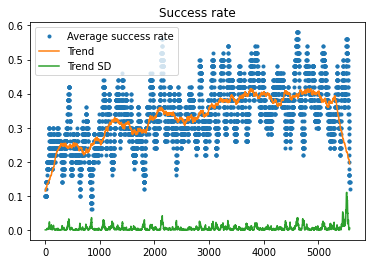

In [11]:
short = np.convolve(success_log, np.ones((50,))/50, mode='same')
trend = np.convolve(success_log, np.ones((500,))/500, mode='same')
trend_sd = (short - np.convolve(success_log, np.ones((500,))/500, mode='same'))**2
plt.plot(short, linestyle="None", marker=".", label="Average success rate")
plt.plot(trend, label="Trend")
plt.plot(trend_sd, label="Trend SD")
plt.legend()
plt.title("Success rate");

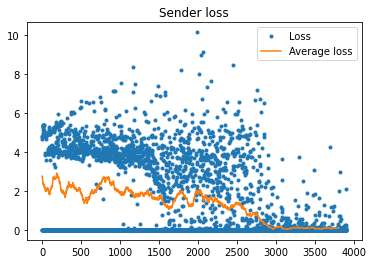

In [35]:
plt.plot(sender_log, linestyle="None", marker=".", label="Loss")
plt.plot(np.convolve(sender_log, np.ones((100,))/100, mode='valid'), label="Average loss")
plt.legend()
plt.title("Sender loss");

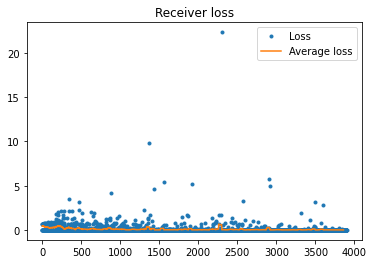

In [36]:
plt.plot(receiver_log, linestyle="None", marker=".", label="Loss")
plt.plot(np.convolve(receiver_log, np.ones((40,))/40, mode='valid'), label="Average loss")
plt.legend()
plt.title("Receiver loss");

In [89]:
receiver.temperature = 60